In [1]:
# 1. IMPORT LIBRARY
# ======================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, callbacks, optimizers, regularizers

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

In [2]:
class ImageClassificationManager:
    """Mengelola path dataset dan membuat data generator."""
    def __init__(self, base_dir, image_size=(128, 128), batch_size=32):
        self.base_dir = base_dir
        self.image_size = image_size
        self.batch_size = batch_size
        
        # Definisikan path
        self.train_dir = os.path.join(base_dir, 'train')
        self.val_dir = os.path.join(base_dir, 'val')
        self.test_dir = os.path.join(base_dir, 'test')
        
        self.datagen = ImageDataGenerator(rescale=1./255)
        self._create_generators()

    def _create_generators(self):
        """Membuat generator untuk data latih, validasi, dan uji."""
        self.train_generator = self.datagen.flow_from_directory(
            self.train_dir,
            target_size=self.image_size,
            batch_size=self.batch_size,
            class_mode='categorical'
        )
        self.validation_generator = self.datagen.flow_from_directory(
            self.val_dir,
            target_size=self.image_size,
            batch_size=self.batch_size,
            class_mode='categorical'
        )
        self.test_generator = self.datagen.flow_from_directory(
            self.test_dir,
            target_size=self.image_size,
            batch_size=self.batch_size,
            class_mode='categorical',
            shuffle=False  # Penting untuk evaluasi
        )
        print(f"\nJumlah kelas ditemukan: {self.train_generator.num_classes}")
        self.class_labels = list(self.train_generator.class_indices.keys())

In [3]:
class CNNModel:
    """Membangun, melatih, dan mengevaluasi model CNN."""
    def __init__(self, input_shape, num_classes, initial_lr=0.001):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.initial_lr = initial_lr
        self.model = self._build_model()
        self._compile_model()

    def _build_model(self):
        """Mendefinisikan arsitektur model CNN."""
        return models.Sequential([
            layers.Conv2D(32, (3,3), activation='relu', input_shape=self.input_shape, kernel_regularizer=regularizers.l2(0.001)),
            layers.MaxPooling2D(2,2),
            layers.Conv2D(64, (3,3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
            layers.MaxPooling2D(2,2),
            layers.Conv2D(128, (3,3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
            layers.MaxPooling2D(2,2),
            layers.Flatten(),
            layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
            layers.Dropout(0.5),
            layers.Dense(self.num_classes, activation='softmax')
        ])

    def _compile_model(self):
        """Mengompilasi model dengan optimizer dan loss function."""
        self.model.compile(
            loss='categorical_crossentropy',
            optimizer=optimizers.Adam(learning_rate=self.initial_lr),
            metrics=['accuracy']
        )

    def train(self, train_gen, val_gen, epochs=30):
        """Melatih model dengan callbacks."""
        lr_schedule = callbacks.LearningRateScheduler(lambda epoch: self.initial_lr * (0.95 ** epoch))
        early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        
        history = self.model.fit(
            train_gen,
            validation_data=val_gen,
            epochs=epochs,
            callbacks=[early_stop, lr_schedule]
        )
        return history

    def evaluate(self, test_gen):
        """Mengevaluasi model pada test set dan mengembalikan hasil."""
        test_gen.reset()
        y_pred_probs = self.model.predict(test_gen)
        y_pred_indices = np.argmax(y_pred_probs, axis=1)
        y_true_indices = test_gen.classes
        
        return y_true_indices, y_pred_indices, y_pred_probs

In [4]:
def plot_training_history(history):
    """Membuat plot riwayat akurasi dan loss pelatihan."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    
    # Plot Akurasi
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Riwayat Akurasi Pelatihan & Validasi')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)
    
    # Plot Loss
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Riwayat Loss Pelatihan & Validasi')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)
    
    plt.show()

def plot_classification_report_heatmap(y_true, y_pred, class_labels):
    """Memvisualisasikan classification report sebagai heatmap."""
    report = classification_report(y_true, y_pred, target_names=class_labels, output_dict=True)
    df_report = pd.DataFrame(report).iloc[:-1, :].T
    
    plt.figure(figsize=(10, 14))
    sns.heatmap(df_report, annot=True, cmap='viridis', fmt='.2f')
    plt.title('Heatmap Laporan Klasifikasi per Kelas')
    plt.show()

def plot_multiclass_roc_auc(y_true, y_pred_probs, class_labels):
    """Membuat plot Kurva ROC untuk setiap kelas (One-vs-Rest)."""
    n_classes = len(class_labels)
    y_true_bin = label_binarize(y_true, classes=range(n_classes))

    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Agregasi Macro
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    plt.figure(figsize=(12, 10))
    plt.plot(fpr["macro"], tpr["macro"],
             label=f'Macro-average ROC (AUC = {roc_auc["macro"]:.2f})',
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC kelas {class_labels[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Kurva ROC Multi-Kelas (One-vs-Rest)')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

===== Mempersiapkan Data Generator =====
Found 8801 images belonging to 31 classes.
Found 2751 images belonging to 31 classes.
Found 1760 images belonging to 31 classes.

Jumlah kelas ditemukan: 31

===== Membangun dan Melatih Model CNN =====
Epoch 1/30
276/276 [==============================] - 120s 431ms/step - loss: 3.3443 - accuracy: 0.1494 - val_loss: 3.0852 - val_accuracy: 0.1963 - lr: 0.0010
Epoch 2/30
276/276 [==============================] - 64s 231ms/step - loss: 2.9323 - accuracy: 0.2357 - val_loss: 2.5511 - val_accuracy: 0.3253 - lr: 9.5000e-04
Epoch 3/30
276/276 [==============================] - 64s 231ms/step - loss: 2.6861 - accuracy: 0.2888 - val_loss: 2.4648 - val_accuracy: 0.3181 - lr: 9.0250e-04
Epoch 4/30
276/276 [==============================] - 64s 232ms/step - loss: 2.5590 - accuracy: 0.3223 - val_loss: 2.1753 - val_accuracy: 0.4300 - lr: 8.5737e-04
Epoch 5/30
276/276 [==============================] - 64s 233ms/step - loss: 2.4425 - accuracy: 0.3561 - val_los

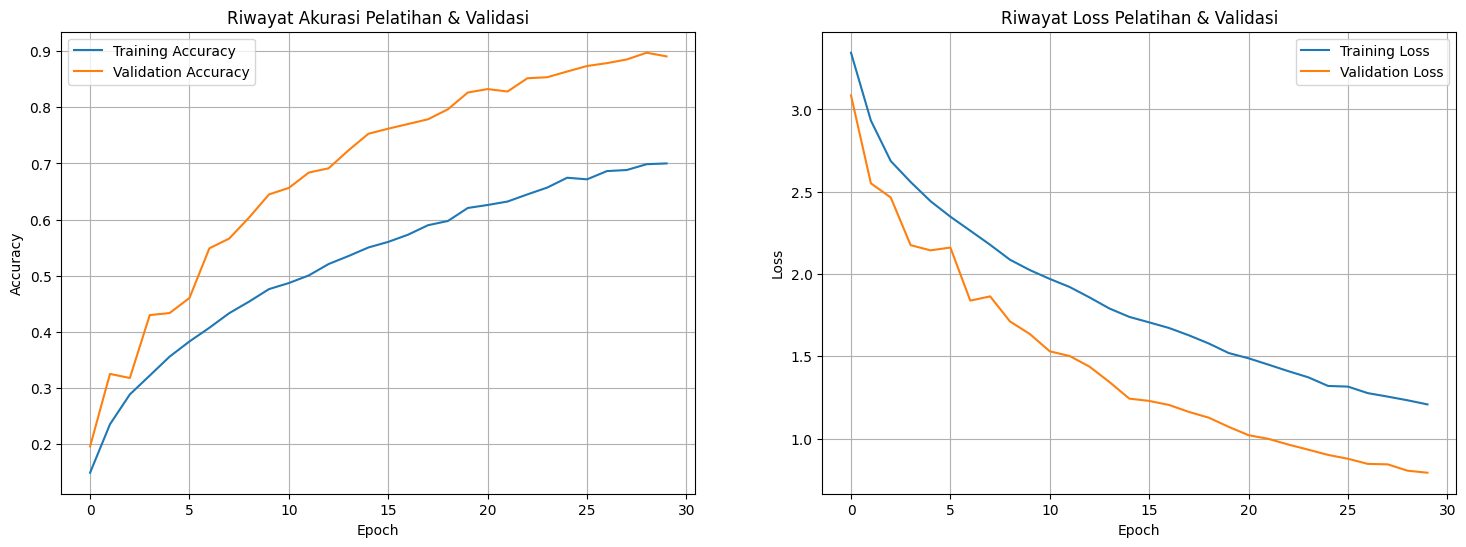

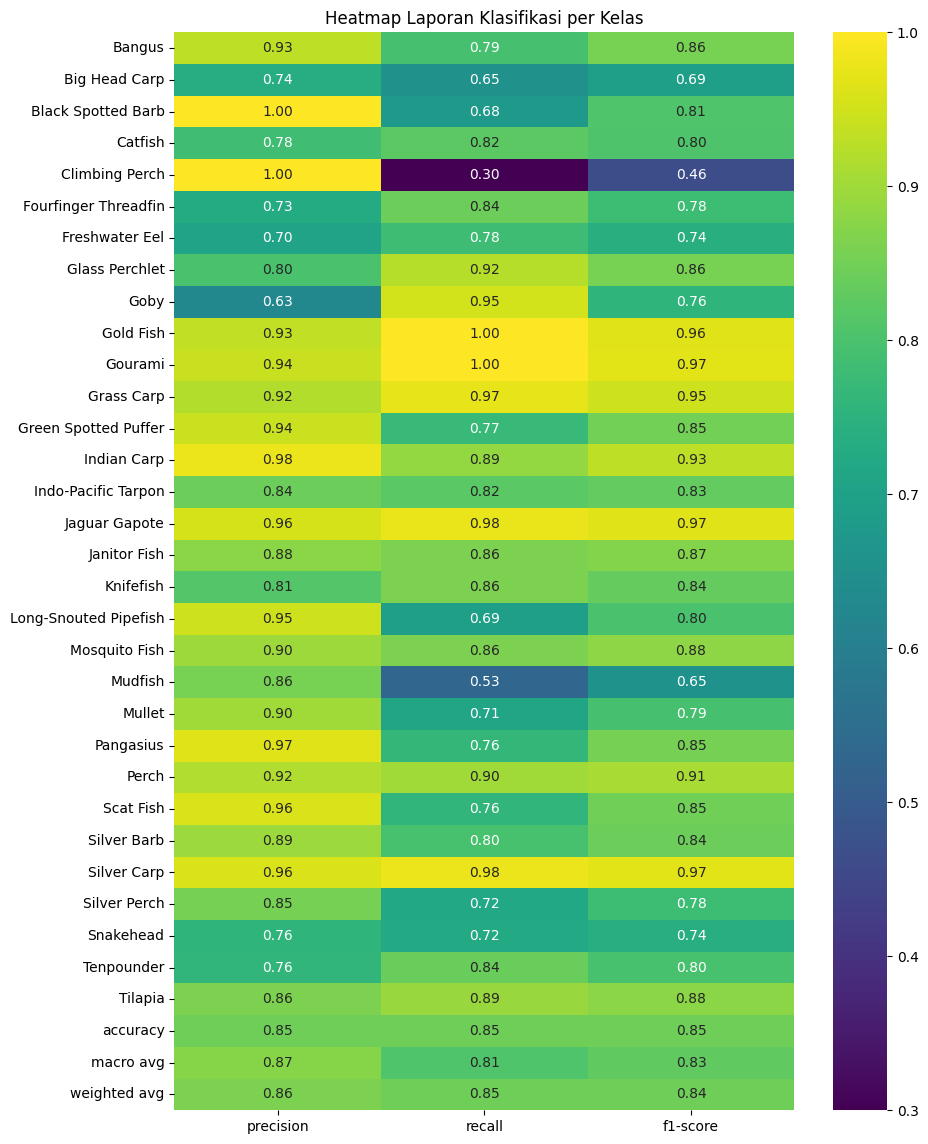

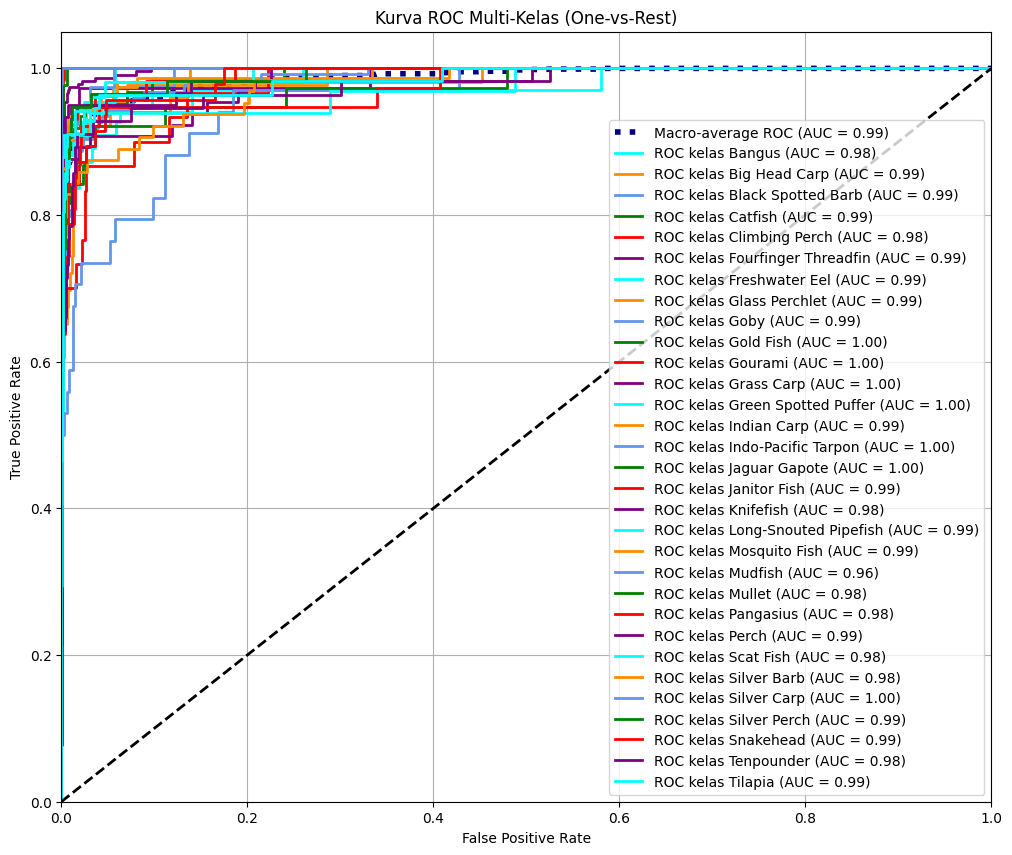

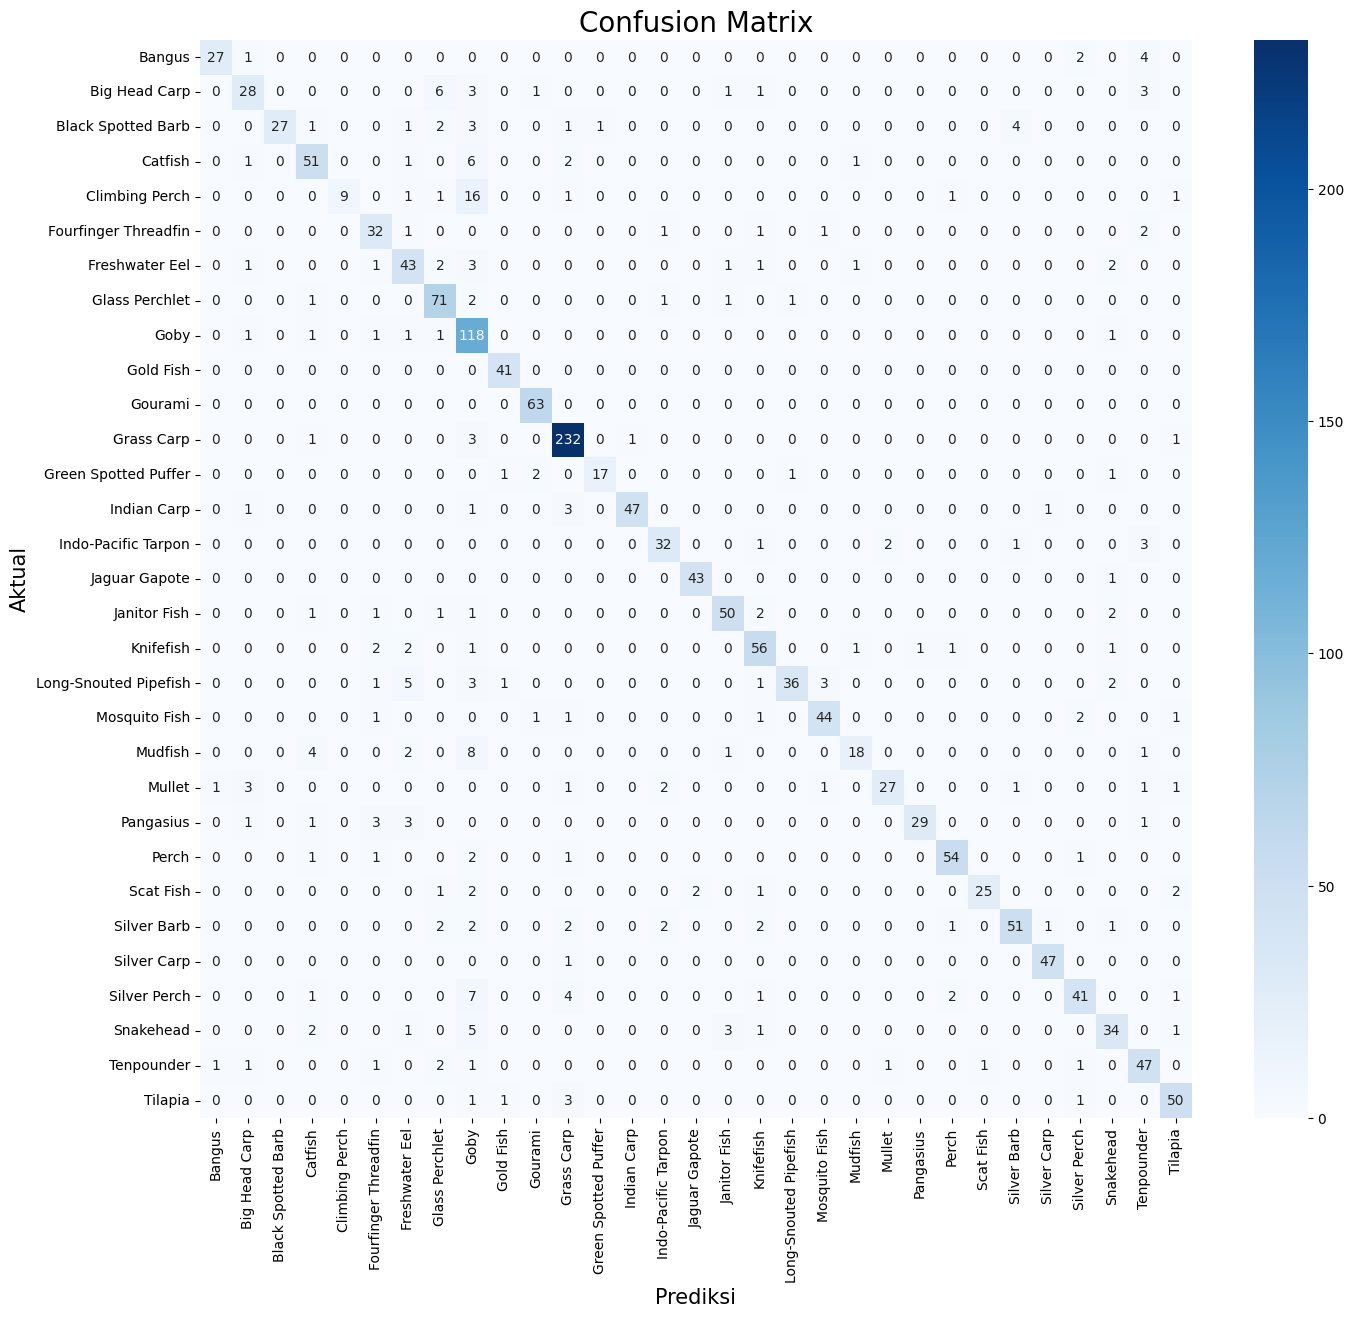

In [5]:
# --- 1. Persiapan Data ---
print("===== Mempersiapkan Data Generator =====")
BASE_DIR = 'FishImgDataset'
data_manager = ImageClassificationManager(base_dir=BASE_DIR)

train_generator = data_manager.train_generator
validation_generator = data_manager.validation_generator
test_generator = data_manager.test_generator
class_labels = data_manager.class_labels

# --- 2. Pembangunan dan Pelatihan Model ---
print("\n===== Membangun dan Melatih Model CNN =====")
cnn_model = CNNModel(
    input_shape=(128, 128, 3),
    num_classes=train_generator.num_classes
)
history = cnn_model.train(train_generator, validation_generator, epochs=30)


# --- 3. Evaluasi dan Visualisasi ---
print("\n===== Mengevaluasi Model dan Membuat Visualisasi =====")
y_true, y_pred, y_pred_probs = cnn_model.evaluate(test_generator)

# Tampilkan metrik dan plot
plot_training_history(history)
plot_classification_report_heatmap(y_true, y_pred, class_labels)
plot_multiclass_roc_auc(y_true, y_pred_probs, class_labels)

# Tampilkan Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(16, 14))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix', fontsize=20)
plt.xlabel('Prediksi', fontsize=15)
plt.ylabel('Aktual', fontsize=15)
plt.show()